In [720]:
import pandas as pd
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from itertools import product
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns


In [680]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


# Train Validation Split

In [681]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [682]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


# Outliers

<Axes: >

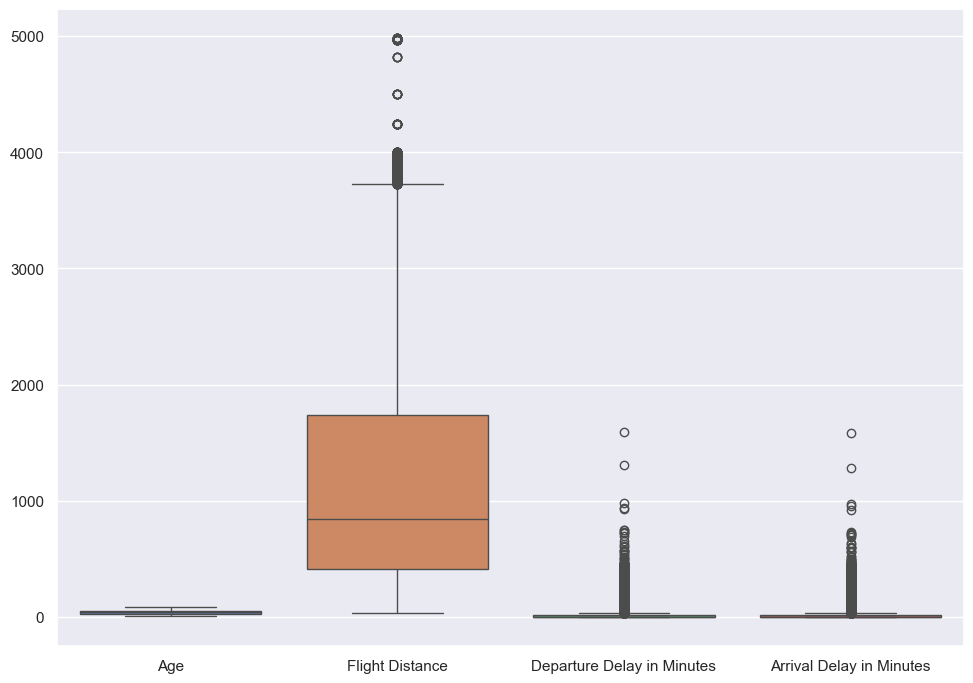

In [683]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=train_df[cols])

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76173, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


<Axes: >

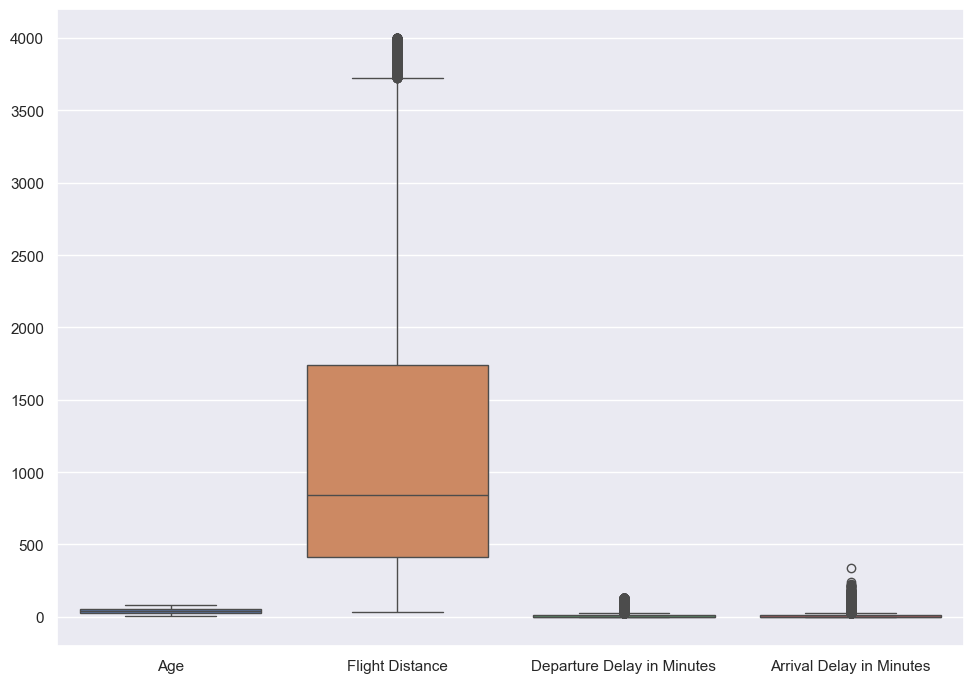

In [684]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)
        
    
print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

sns.boxplot(data=train_df[cols])

# Enconding

## Class Variable

In [685]:
classes_dict = {
    'neutral or dissatisfied': 0,
    'satisfied': 1
}
def ord_encode(x):
    return classes_dict[x]

dec_class = 'satisfaction'
print('Before Encoding: ', train_df[dec_class].values)
train_df[dec_class] = train_df[dec_class].map(ord_encode)
validation_df[dec_class] = validation_df[dec_class].map(ord_encode)
print('After Encoding: ', train_df[dec_class].values)


Before Encoding:  ['neutral or dissatisfied' 'satisfied' 'neutral or dissatisfied' ...
 'neutral or dissatisfied' 'neutral or dissatisfied' 'satisfied']
After Encoding:  [0 1 0 ... 0 0 1]


## One Hot Enconding

In [686]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,False,True,False
1,False,False,False
2,True,True,False
3,False,True,False
4,True,True,False
...,...,...,...
76168,True,False,False
76169,True,False,False
76170,False,True,False
76171,False,False,False


## Ordinal Enconding

In [687]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].map(ord_encode)
validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].map(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Business']
 ['Business']
 ['Eco']
 ...
 ['Eco Plus']
 ['Business']
 ['Business']]
After Encoding:  [[2]
 [2]
 [0]
 ...
 [1]
 [2]
 [2]]


# Correlation

## Continuous Variables

Needs to be done before Binning

<Axes: >

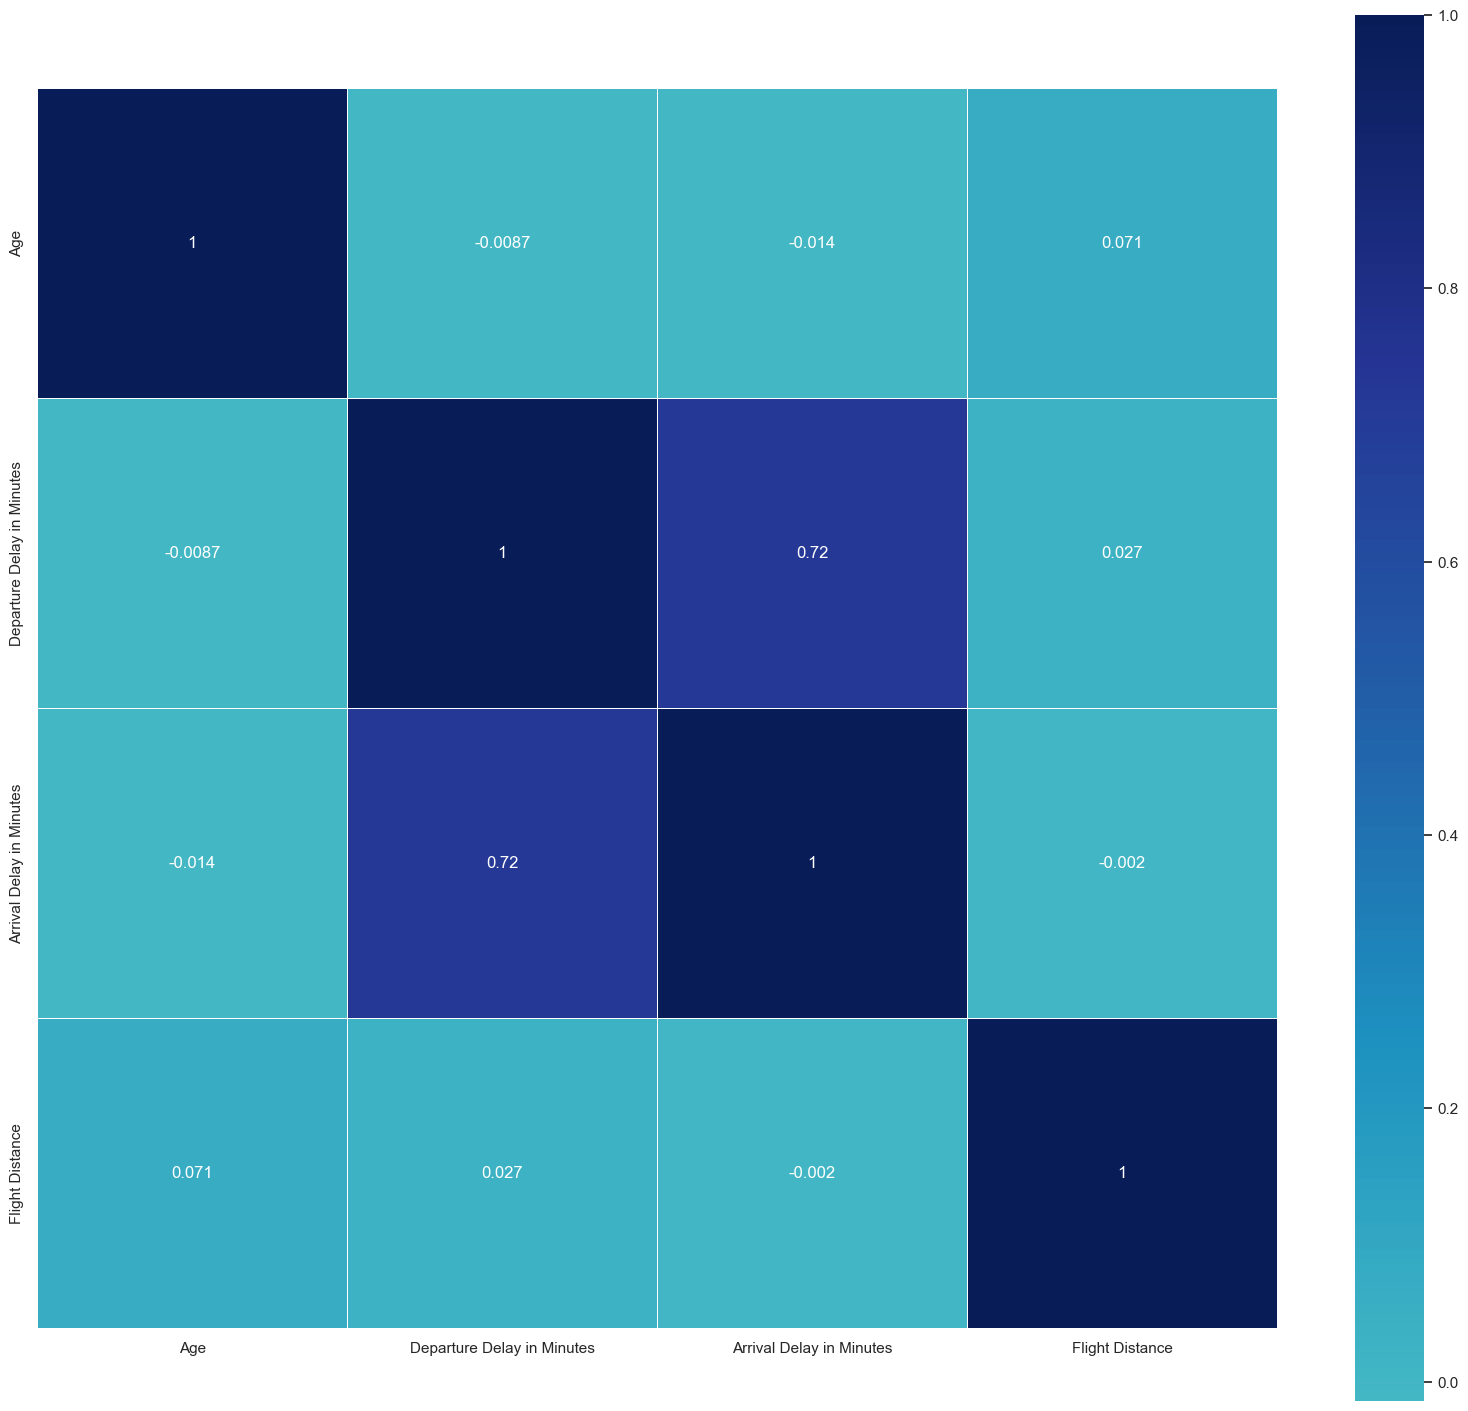

In [688]:
columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

corr = train_df[columns].corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)

In [689]:
corr

,Age,Departure Delay in Minutes,Arrival Delay in Minutes,Flight Distance
Age,1.000000,-0.008702,-0.014026,0.070694
Departure Delay in Minutes,-0.008702,1.000000,0.721102,0.027207
Arrival Delay in Minutes,-0.014026,0.721102,1.000000,-0.002023
Flight Distance,0.070694,0.027207,-0.002023,1.000000


## Categorical Variables (Chi Squared Test)

In [690]:
columns = ['Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction', 'Type of Travel_Personal Travel', 'Gender_Male',
       'Customer Type_disloyal Customer']

print('Shape Before dropna: ', train_df[columns].shape)
df_corr = train_df[columns].dropna()
print('Shape After dropna: ', df_corr.shape)

cat_var_prod = list(product(columns,columns, repeat = 1))

result = []
for i in cat_var_prod:
       if i[0] != i[1]:
              result.append((i[0],i[1],list(stats.chi2_contingency(pd.crosstab(df_corr[i[0]], df_corr[i[1]])))[1]))
result

Shape Before dropna:  (76173, 19)
Shape After dropna:  (76173, 19)


[('Class', 'Inflight wifi service', 0.0),
 ('Class', 'Departure/Arrival time convenient', 0.0),
 ('Class', 'Ease of Online booking', 0.0),
 ('Class', 'Gate location', 0.0),
 ('Class', 'Food and drink', 3.6318741544950463e-184),
 ('Class', 'Online boarding', 0.0),
 ('Class', 'Seat comfort', 0.0),
 ('Class', 'Inflight entertainment', 0.0),
 ('Class', 'On-board service', 0.0),
 ('Class', 'Leg room service', 0.0),
 ('Class', 'Baggage handling', 0.0),
 ('Class', 'Checkin service', 0.0),
 ('Class', 'Inflight service', 0.0),
 ('Class', 'Cleanliness', 0.0),
 ('Class', 'satisfaction', 0.0),
 ('Class', 'Type of Travel_Personal Travel', 0.0),
 ('Class', 'Gender_Male', 0.024267351939358046),
 ('Class', 'Customer Type_disloyal Customer', 2.0732817107987983e-240),
 ('Inflight wifi service', 'Class', 0.0),
 ('Inflight wifi service', 'Departure/Arrival time convenient', 0.0),
 ('Inflight wifi service', 'Ease of Online booking', 0.0),
 ('Inflight wifi service', 'Gate location', 0.0),
 ('Inflight wifi s

<Axes: >

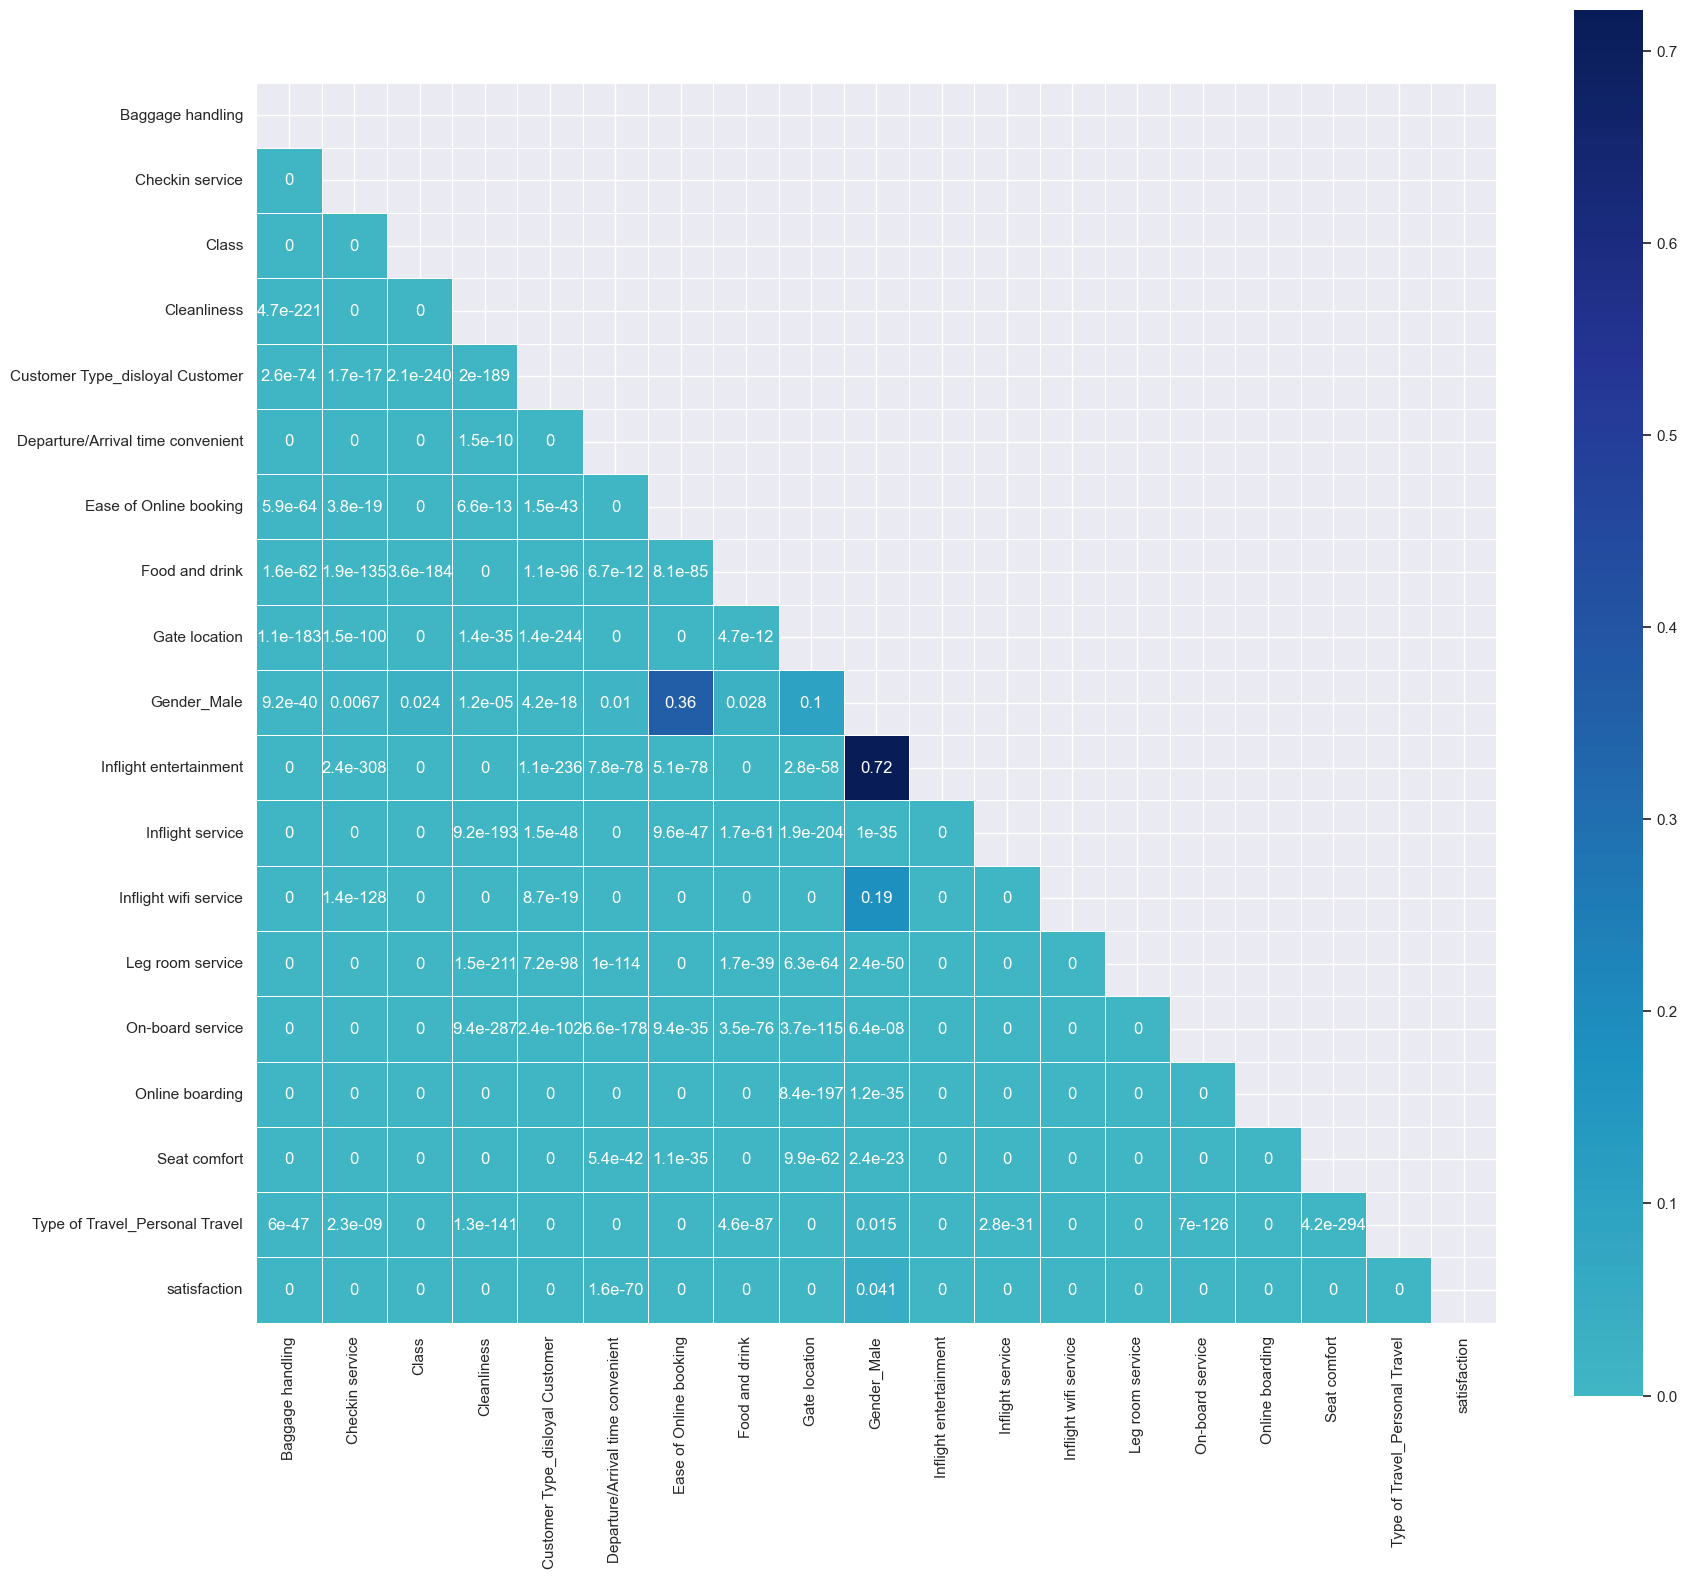

In [691]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 
                                                       'corr'])

chi_test_output = chi_test_output.pivot(index='var1', columns='var2', values='corr')
chi_test_output =  chi_test_output.rename_axis(None, axis=1) 
chi_test_output =  chi_test_output.rename_axis(None, axis=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(chi_test_output, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chi_test_output, annot = True, mask=mask, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)


# Binning

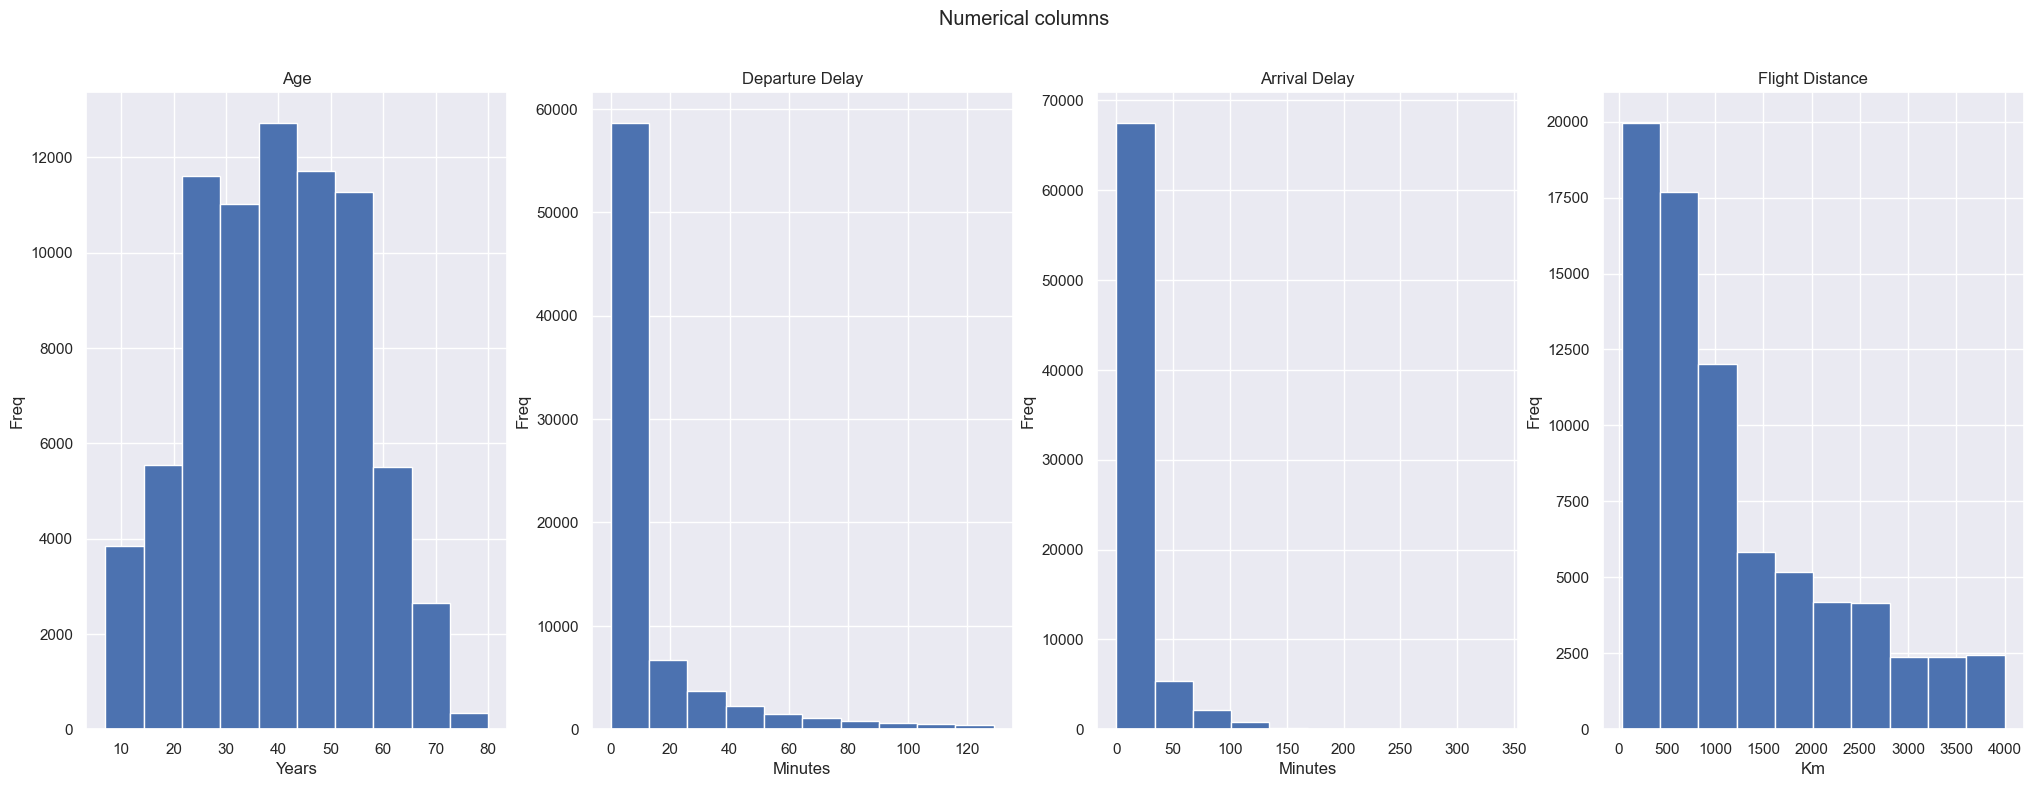

In [692]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'])

ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'])

ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'])

ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'])

plt.show()

In [693]:
def dist_binning(column: str):
    # 4 bins
    boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)
    
    print(f'{column} boundary to split: ', boundary)

    bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
    print('Bin means: ', bins_means)

    def binnign_method(age) -> int:

        if np.isnan(age):
            return np.nan
        
        if age < boundary:
            return bins_means[0]
        
        if age < 2*boundary:
            return bins_means[1]
        
        if age < 3*boundary:
            return bins_means[2]
        
        if age < 4*boundary:
            return bins_means[3]

    print(f'{column} before binning: ', train_df[column].head(10))
    train_df[column] = train_df[column].map(binnign_method)
    validation_df[column] = validation_df[column].map(binnign_method)
    print(f'{column} After binning: ', train_df[column].head(10))


### Age

In [694]:
dist_binning(column='Age')

Age boundary to split:  19
Bin means:  [14, 29, 47, 63]
Age before binning:  0    26
1    36
2    50
3    49
4    29
5    55
6    16
7    57
8    30
9     8
Name: Age, dtype: int64
Age After binning:  0    29.0
1    29.0
2    47.0
3    47.0
4    29.0
5    47.0
6    14.0
7    63.0
8    29.0
9    14.0
Name: Age, dtype: float64


### Departure Delay

In [695]:
dist_binning(column='Departure Delay in Minutes')

Departure Delay in Minutes boundary to split:  33
Bin means:  [4, 47, 81, 113]
Departure Delay in Minutes before binning:  0    46
1     0
2    23
3     0
4     0
5     0
6     0
7     0
8    60
9     0
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes After binning:  0    47
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8    47
9     4
Name: Departure Delay in Minutes, dtype: int64


### Arrival Delay

In [696]:
dist_binning(column='Arrival Delay in Minutes')

Arrival Delay in Minutes boundary to split:  85
Bin means:  [9, 107, 190, 337]
Arrival Delay in Minutes before binning:  0    20.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8    55.0
9     0.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes After binning:  0    9.0
1    9.0
2    9.0
3    9.0
4    9.0
5    9.0
6    9.0
7    9.0
8    9.0
9    9.0
Name: Arrival Delay in Minutes, dtype: float64


### Flight Distance

In [697]:
dist_binning(column='Flight Distance')

Flight Distance boundary to split:  993
Bin means:  [497, 1424, 2440, 3482]
Flight Distance before binning:  0    2586
1     521
2    2174
3      89
4     622
5    3546
6     351
7    2583
8    1814
9     430
Name: Flight Distance, dtype: int64
Flight Distance After binning:  0    2440.0
1     497.0
2    2440.0
3     497.0
4     497.0
5    3482.0
6     497.0
7    2440.0
8    1424.0
9     497.0
Name: Flight Distance, dtype: float64


In [698]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,75954.000000,76173.000000,75992.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,76173.000000,75976.000000,76173.000000
mean,40.023001,1.026072,1179.574692,2.728959,3.063395,2.753351,2.974505,3.208722,3.248986,3.444528,3.362674,3.387447,3.342444,3.629422,3.306985,3.649915,3.287819,10.745093,11.433492,0.434826
std,14.068863,0.963195,949.288184,1.329504,1.526245,1.399019,1.277291,1.328370,1.351187,1.320561,1.333451,1.286599,1.318757,1.182942,1.261868,1.172978,1.313098,20.454348,15.481802,0.495737
min,14.000000,0.000000,497.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,9.000000,0.000000
25%,29.000000,0.000000,497.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,9.000000,0.000000
50%,47.000000,1.000000,497.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,9.000000,0.000000
75%,47.000000,2.000000,1424.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,9.000000,1.000000
max,63.000000,2.000000,3482.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,113.000000,337.000000,1.000000


# Missing Values

In [699]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Age', 'Flight Distance', 'Arrival Delay in Minutes'], dtype='object')
Index([], dtype='object')


In [700]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')


Index([], dtype='object')

# Min Max Scaling

In [701]:
columns = ['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = MinMaxScaler()
f_scaler=scaler.fit(train_df[columns])

# Train
train_df[columns] = f_scaler.transform(train_df[columns])

# Validation
validation_df[columns] = f_scaler.transform(validation_df[columns])

# OverSampling

In [702]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 1]), ' not satisfied: ', len(y[y['satisfaction'] != 1]))
  print('satisfied: {:.2f}%'.format(len(y[y['satisfaction'] == 1])/len(y) * 100), ' not satisfied: {:.2f}%'.format(len(y[y['satisfaction'] != 1])/len(y) * 100), '\n')

In [703]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76173
satisfied:  33122  not satisfied:  43051
satisfied: 43.48%  not satisfied: 56.52% 

total:  86102
satisfied:  43051  not satisfied:  43051
satisfied: 50.00%  not satisfied: 50.00% 



In [704]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied: 43.33%  not satisfied: 56.67% 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied: 50.00%  not satisfied: 50.00% 



# Experimento com Modelos

In [705]:
X_train, X_test, y_train, y_test = train_test_split(x_train_df, y_train_df, test_size=0.95, stratify=y_train_df['satisfaction'])

X_train.shape, y_train.shape

((8610, 22), (8610, 1))

In [706]:
def plot_confusion(y_true, y_pred, title):
 disp = ConfusionMatrixDisplay.from_predictions(
 y_true,
 y_pred,
 cmap=plt.cm.Blues,
 normalize=None,
 )
 disp.ax_.set_title(title)
 plt.show()

## MLP - Scikit

In [715]:
mlp = MLPClassifier(random_state=42, max_iter=400)

scoring = ['precision', 'recall', 'f1']
pipe = Pipeline(steps=[("mlp", mlp)])
  
hidden_layer_sizes = [(5,), (5,10,)]

activation = ['logistic', 'tanh', 'relu']
solver = ['sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

parameters = dict(
  mlp__hidden_layer_sizes=hidden_layer_sizes,
  mlp__activation=activation,
  mlp__solver=solver,
  mlp__learning_rate=learning_rate
)

mlp_RS = RandomizedSearchCV(pipe, parameters, scoring=scoring, n_jobs=-1, refit='f1', n_iter=10, cv=10)

mlp_RS.fit(X_train.values, y_train.values.ravel())

best_mlp_hidden_layer = mlp_RS.best_estimator_.get_params()["mlp__hidden_layer_sizes"]
best_mlp_activation = mlp_RS.best_estimator_.get_params()["mlp__activation"]
best_mlp_solver = mlp_RS.best_estimator_.get_params()["mlp__solver"]
best_mlp_learning_rate = mlp_RS.best_estimator_.get_params()["mlp__learning_rate"]

print("Best hidden_layer_sizes:", mlp_RS.best_estimator_.get_params()["mlp__hidden_layer_sizes"])
print("Best Activation:", mlp_RS.best_estimator_.get_params()["mlp__activation"])
print("Best Solver:", mlp_RS.best_estimator_.get_params()["mlp__solver"])
print("Best Learning Rate:", mlp_RS.best_estimator_.get_params()["mlp__learning_rate"])

Best hidden_layer_sizes: (5, 10)
Best Activation: tanh
Best Solver: adam
Best Learning Rate: constant


              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4305
           1       0.93      0.94      0.93      4305

    accuracy                           0.93      8610
   macro avg       0.93      0.93      0.93      8610
weighted avg       0.93      0.93      0.93      8610



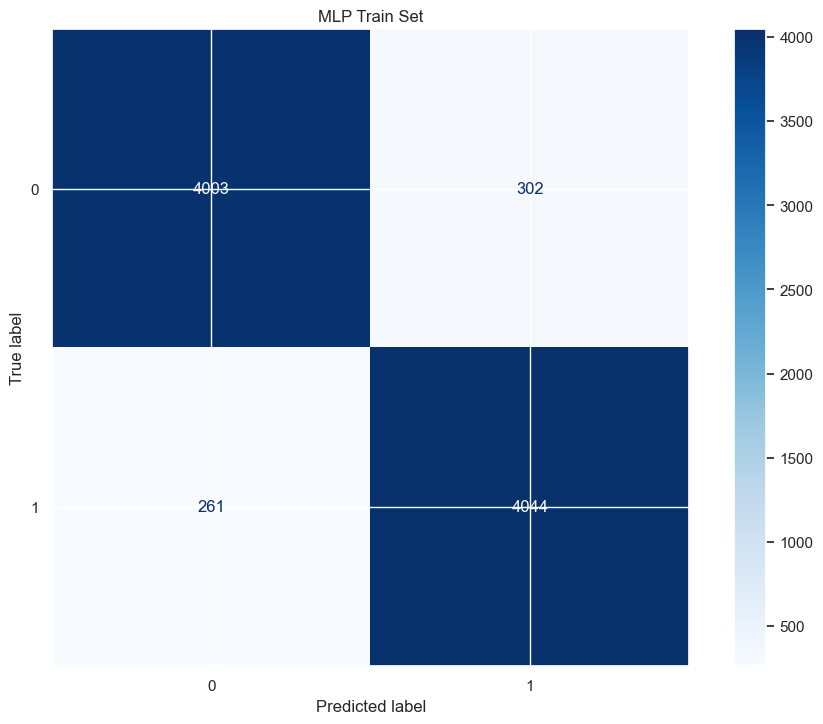

In [719]:
y_pred = mlp_RS.predict(X_train.values)
print(classification_report(y_train, y_pred))
plot_confusion(y_train, y_pred, "MLP Train Set")

## MLP - Torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RF